In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
import json
import pickle
import re
import pprint
import datetime
import statistics as st

In [3]:
import sqlite3
high_performance_mode = False #Changed this to default false
db_file_path = "db.db" #CHANGE THIS
from urllib.parse import unquote
from urllib.parse import quote

In [4]:
##DO NOT TOUCH THESE
db = sqlite3.connect(":memory:")
db2 = sqlite3.connect(db_file_path)
##DO NOT TOUCH THESE
if high_performance_mode:
    db2.backup(db)
    db2.close()
else:
    db = db2
db.execute('PRAGMA journal_mode = MEMORY')
#Rollback journal in mem so that indexing is faster and crashes are catastrophic >:D
db.execute('PRAGMA cache_size = 536870912') #<- 512MB in B
#This is dinamically resized but the default is really low so let it grow!
db.execute('PRAGMA temp_store = MEMORY')
#Anything that needs to be generated, do it in mem because faster
db.execute('PRAGMA locking_mode = EXCLUSIVE')
#Remove lock/unlock overhead let it zoom
print("Loaded")

Loaded


In [5]:
c = db.cursor()
class Helper:
      def __init__(self, db):
        self.db = db;
        #If anybody wants to use this Google "SQLite IN"
        self.airline_names = {20626359: 'virginatlantic', 18332190: 'British Airways', 22536055: 'American Airlines', 1542862735: 'Ryanair', 38676903: 'easyJet', 124476322: 'Lufthansa', 218730857: 'Qantas', 106062176: 'Air France', 56377143: 'Royal Dutch Airlines', 45621423: 'SocialLogin%40etihad.ae', 253340062: 'Singapore Airlines', 26223583: 'airberlin', 2182373406: 'airberlin Assist'}
        self.airline_ids = [56377143, 106062176, 18332190, 22536055, 124476322, 26223583, 2182373406, 38676903, 1542862735, 253340062, 218730857, 45621423, 20626359]
      def exec_custom(self, query: str):
        return self.db.execute(query)
      def get_vars(self, table: str):
        return self.db.execute("pragma table_info('{0}');".format(table))
      def get_tables(self): 
        return self.db.execute("SELECT name FROM sqlite_master WHERE type ='table' AND name NOT LIKE 'sqlite_%';")
      def get_tweet(self, id: int, vars, filter):
        return self.db.execute(self.build_query('tweets', vars, filter))
      def get_user_tweets(self, id: int):
        return self.db.execute(self.build_query('tweets', '*', [['user', id]]))
      def get_airline_tweets_by_mention(self, id: int, vars):
        return self.db.execute(self.build_query('mentions', vars, "WHERE user_id = '{0}'".format(id)))
      def get_airline_tweets_by_user_id_in_tweet(self, id: int, vars):
        return self.db.execute(self.build_query('tweets', vars, "WHERE user = '{0}'".format(id)))
      def build_query(self, table, return_values, search_values, raw_filter = 0):
        def createLimit(limit: list):
            return limit[0] + " = " + "'{0}'".format(limit[1])
        #You'd have to sort and/or/* search values and then apply them accordingly because of how the .join function works and im not about that life
        #Or use the list comprehension output to process the logic behind it (but usually complex things require brackets and f that)
        if(type(search_values) == list):
            query = "select " + ",".join(return_values) + " from " + table + " where " + ' and '.join([createLimit(limit) for limit in search_values])
        else:
            query = "select " + ",".join(return_values) + " from " + table + " where " + search_values
        return query


In [6]:
hp = Helper(c)

In [7]:
#See all tables
hp_t = Helper(db)
for table_name in hp_t.get_tables():
    print('<[{0}]>'.format(table_name[0]))
    for column_name in hp_t.get_vars(table_name[0]):
        print("    {0}".format(column_name[1]))

<[tweets]>
    id
    text
    in_reply_to_status_id
    in_reply_to_user_id
    user
    retweeted_status
    quoted_status
    language
    timestamp_ms
<[users]>
    timestamp
    id
    name
    verified
    followers_count
    friends_count
    listed_count
    favourites_count
    statuses_count
    location
<[retweets]>
    id
    in_reply_to_status_id
    in_reply_to_user_id
    user
<[quotes]>
    id
    in_reply_to_status_id
    in_reply_to_user_id
    user
<[to_delete]>
    id
    timestamp
<[ent_hashtags]>
    id
    text
<[ent_urls]>
    id
    url
<[ent_mentions]>
    id
    name
    user_id
<[convs]>
    root
    reply
    id
    level


In [8]:
airlines = {'KLM':56377143, 
            'AirFrance': 106062176, 
            'British_Airways': 18332190, 
            'AmericanAir': 22536055, 
           'Lufthansa': 124476322, 
           'AirBerlin': 26223583, 
           'AirBerlinAssist': 2182373406, 
           'easyJet': 38676903, 
           'RyanAir': 1542862735, 
           'SingaporeAir': 253340062, 
           'Qantas': 218730857, 
           'EtihadAirways': 45621423, 
           'VirginAtlantic': 20626359}

In [9]:
air_count = pickle.load(open("save2.p", "rb"))

In [10]:
del air_count['AirBerlin']['nr_conv']
del air_count['AirBerlinAssist']['nr_conv']

- KLM received about 133 000 tweets from users (whether directly or as a reply)
- did they reply more to famous users? (famous defined as users with more than 5000 followers)

In [11]:
q1 = """
SELECT COUNT(DISTINCT(tweets.id))
FROM users, tweets
WHERE users.id = tweets.user AND users.id = 56377143 AND tweets.in_reply_to_user_id != 'null'
AND tweets.in_reply_to_user_id IN (SELECT id FROM users WHERE followers_count > 5000);
"""
for row in hp.exec_custom(q1):
    print(row)

(1564,)


# A-B-A structure for the sentiment analysis

First, find the tweets from users that get a reply later on

In [12]:
unfiltered_a_q = """
SELECT DISTINCT(id) as 'start', user as 'user_id'
FROM tweets
WHERE tweets.user != 56377143 AND tweets.id IN ({0}) AND tweets.in_reply_to_user_id = 'null' 
AND id IN (SELECT DISTINCT(in_reply_to_status_id) FROM tweets WHERE user = 56377143 AND in_reply_to_status_id != 'null')
""".format(','.join([str(x) for x in air_count['KLM']['ids']]))

unfiltered_a = pd.read_sql_query(unfiltered_a_q, db)
unfiltered_a

,start,user_id
0,1131185677230575600,824207173425262600
1,1131215415164702700,123663454
2,1131260934087991300,267418667
3,1131277493674156000,2186639444
4,1131281689051828200,977096243204804600
...,...,...
3449,1243899605483323400,66617261
3450,1243920892272562200,187541638
3451,1244183751820742700,934431504
3452,1244521027285045200,52662462


We have to filter these tweets to those that end in a ABA structured converstion 

   - going backwards from the third (A) tweet to klm's reply (B) 

In [13]:
b_tweets_id = """(SELECT DISTINCT(id) FROM tweets WHERE tweets.user = 56377143 AND in_reply_to_status_id IN ({0}))""".format( ','.join([str(x) for x in unfiltered_a['start']]))
b_tweets_in_reply_user = """(SELECT DISTINCT(in_reply_to_user_id) FROM tweets WHERE tweets.user = 56377143 AND in_reply_to_status_id IN ({0}))""".format( ','.join([str(x) for x in unfiltered_a['start']]))
a_tweets = """(SELECT DISTINCT(in_reply_to_status_id) FROM tweets WHERE tweets.user = 56377143 AND in_reply_to_status_id IN ({0}))""".format( ','.join([str(x) for x in unfiltered_a['start']]))
backward_a_b_q = """
SELECT DISTINCT(id) as 'change', user as 'user_id', in_reply_to_status_id as 'klms reply'
FROM tweets
WHERE tweets.user != 56377143 AND tweets.id IN ({0}) AND tweets.user IN {1}
AND tweets.in_reply_to_status_id IN {2}
""".format(','.join([str(x) for x in air_count['KLM']['ids']]), b_tweets_in_reply_user, b_tweets_id)
backward_a_b = pd.read_sql_query(backward_a_b_q, db)
backward_a_b

,change,user_id,klms reply
0,1131190988561629200,824207173425262600,1131188287803142100
1,1131191297312723000,824207173425262600,1131188287803142100
2,1131283711679508500,2186639444,1131282681692610600
3,1131283955230105600,977096243204804600,1131283320266993700
4,1131503882079809500,146872603,1131502675101659100
...,...,...,...
770,1243722308457361400,73875631,1243715503677415400
771,1244351715790459000,1935225229,1243766315908837400
772,1244550930365927400,146872603,1244550301018992600
773,1244559335902118000,146872603,1244550301018992600


- first (A) tweets from users that ended in a conversation

In [14]:
a_tweets_q = """
SELECT in_reply_to_status_id as 'start'
FROM tweets
WHERE id IN ({0})
""".format(','.join([str(x) for x in backward_a_b['klms reply']]))
a_tweets = pd.read_sql_query(a_tweets_q, db)
a_tweets

,start
0,1131185677230575600
1,1131277493674156000
2,1131277493674156000
3,1131281689051828200
4,1131281689051828200
...,...
719,1243172327854047200
720,1243702683564834800
721,1241403462379884500
722,1244545235130220500


# Sentiment change on conversations

In [17]:
import numpy as np
import re
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
#from emoji_unicode import UNICODE_EMO
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.text import Text
import string, re
from textblob_nl.nl import sentiment as pattern_sentiment
from textblob.classifiers import NaiveBayesClassifier
from textblob.sentiments import NaiveBayesAnalyzer
pd.set_option('max_colwidth', 1000)
import seaborn as sns
import matplotlib.pyplot as plt
import pymongo
from pymongo import MongoClient

In [18]:
client = MongoClient('localhost', 27017)
mydb = client.tweet
convos = mydb['convos']
tweets = mydb['_tweets']

In [19]:
klm_df = pd.DataFrame()
klm_df['tweet'] = [t['text'] for t in tweets.find({}) if 'KLM' in t['text'] if t['language']=='eng']
klm_df['id'] = [t['id'] for t in tweets.find({}) if 'KLM' in t['text'] if t['language']=='eng']
klm_df['user_id'] = [t['user']['id'] for t in tweets.find({}) if 'KLM' in t['text'] if t['language']=='eng']
klm_df['timestamp'] = [t['timestamp_ms'] for t in tweets.find({}) if 'KLM' in t['text'] if t['language']=='eng']

In [153]:
#klm_df

#### First-A tweets dataframe

In [21]:
id_list = []
for i in a_tweets['start']:
    for j in klm_df['id']:
        if j == i:
            id_list.append(j)
len(id_list)

478

In [37]:
c_df = pd.DataFrame()
c_df['tweet'] = [t['text'] for t in tweets.find({}) for i in id_list if i == t['id'] if t['language']=='eng']
c_df['id'] = [t['id'] for t in tweets.find({}) for i in id_list if i == t['id'] if t['language']=='eng']
c_df['user_id'] = [t['user']['id'] for t in tweets.find({}) for i in id_list if i == t['id'] if t['language']=='eng']
c_df['timestamp'] = [t['timestamp_ms'] for t in tweets.find({}) for i in id_list if i == t['id'] if t['language']=='eng']

In [38]:
#c_df

In [39]:
c_df.drop_duplicates(inplace=True)
#c_df #443

In [40]:
#function which cleans the text 
def cleantxt(text):
    text = text.lower()
    text = re.sub('airline', '', text)
    text = re.sub('travel', '', text)
    text = re.sub('airways', '', text)
    text = re.sub('amp', '', text)
    text = re.sub('amsterdam', '', text)
    text = re.sub('people', '', text)
    text = re.sub('flight', '', text)
    text = re.sub('\[.*?\]', '', text) 
    text = re.sub(r'@[A-Za-z0-9]+', '', text) 
    text = re.sub(r'https?:\/\/\S+', '', text) 
    text = re.sub(r'RT[\s]+', '', text) 
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\n', '', text)
    #for emot in UNICODE_EMO:
    #    text = re.sub(r'('+emot+')', "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()), text)
    return text

In [41]:
c_df['tweet'] = c_df['tweet'].apply(cleantxt)
#c_df[['tweet']]

In [42]:
from collections import Counter
cnt = Counter()
for text in c_df["tweet"].values:
    for word in text.split():
        cnt[word] += 1
        
#cnt.most_common(20)

In [43]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(40)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

c_df['tweet'] = c_df['tweet'].apply(remove_freqwords)
#_df[['tweet']].head()

In [259]:
#removing emojis
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

c_df['tweet'] = c_df['tweet'].apply(deEmojify)

In [260]:
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

In [261]:
def getAnalysis(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'

In [262]:
c_df['polarity'] = c_df['tweet'].apply(getPolarity)
c_df['subjectivity'] = c_df['tweet'].apply(getSubjectivity)
c_df['analysis'] = c_df['polarity'].apply(getAnalysis)

In [263]:
#c_df

In [264]:
c_df['polarity'].describe() # mean sentiment is 0.03

count    443.000000
mean       0.038061
std        0.270283
min       -1.000000
25%       -0.080556
50%        0.021429
75%        0.200000
max        0.800000
Name: polarity, dtype: float64

#### Second-A tweets dataframe 

In [265]:
id_list2 = []
for i in backward_a_b['change']:
    for j in klm_df['id']:
        if j == i:
            id_list2.append(j)
len(id_list2)

486

In [50]:
c_df2 = pd.DataFrame()
c_df2['tweet'] = [t['text'] for t in tweets.find({}) for i in id_list2 if i == t['id'] if t['language']=='eng']
c_df2['id'] = [t['id'] for t in tweets.find({}) for i in id_list2 if i == t['id'] if t['language']=='eng']
c_df2['user_id'] = [t['user']['id'] for t in tweets.find({}) for i in id_list2 if i == t['id'] if t['language']=='eng']
c_df2['timestamp'] = [t['timestamp_ms'] for t in tweets.find({}) for i in id_list2 if i == t['id'] if t['language']=='eng']

In [51]:
c_df2.drop_duplicates(inplace=True)
#c_df2

In [52]:
c_df2['tweet'] = c_df2['tweet'].apply(cleantxt)
#c_df2[['tweet']]

In [53]:
from collections import Counter
cnt = Counter()
for text in c_df2["tweet"].values:
    for word in text.split():
        cnt[word] += 1
        
#cnt.most_common(40)

In [54]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(40)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

c_df2['tweet'] = c_df2['tweet'].apply(remove_freqwords)
#c_df2[['tweet']].head()

In [266]:
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

c_df2['tweet'] = c_df2['tweet'].apply(deEmojify)

In [267]:
c_df2['polarity'] = c_df2['tweet'].apply(getPolarity)
c_df2['subjectivity'] = c_df2['tweet'].apply(getSubjectivity)
c_df2['analysis'] = c_df2['polarity'].apply(getAnalysis)

In [268]:
c_df2['polarity'].describe() # mean sentiment is 0.08

count    486.000000
mean       0.086636
std        0.240292
min       -1.000000
25%       -0.012798
50%        0.066667
75%        0.216406
max        0.900000
Name: polarity, dtype: float64

* Since TextBlob isnt so accurate decided to use Naive Bayes Classifier again

In [269]:
train = [
    ('i wish the food service was better', 'neg'),
    ('Great costumer service!', 'pos'),
    ('I am happy with the flight and service', 'pos'),
    ('glad I chose this airline', 'pos'),
    ('fucking costumer service is so bad', 'neg'),
    ('The flight was late, I am not happy with this', 'neg'),
    ('I will never fly with this airline again', 'neg'),
    ('Airline sucks at organization, total nightmare', 'neg'),
    ('Staff was very helpful, very nice', 'pos'),
    ('great to see such developments!', 'pos'),
    ('Today was my last trip outside schengen with klm / amsterdam is the worst airport for international connecting flights', 'neg'),
    ('I like flying with this airline!', 'pos'),
    ('its not helping me at all. Companies too big to solve real problems', 'neg'),
    ('your staff seemingly unaware', 'neg'),
    ('Thank you. But thats not enough. If my flight is delayed more than 3 hours, you must advise Im entitled to assistance AND compensation. Not just say download the brochure.', 'neg'),
    ('worst experience in my life,', 'neg'),
    ('last minute flight cancellation, very dissapointed', 'neg'),
    ('great job at cancelling our flight again!', 'neg'), #sarcasm
    ('you have truly excelled yourself in providing the worst customer service ever', 'neg'), #sarcasm
    ('the food on this airplane was delicious', 'pos'),
    ('delighted with the costumer service here', 'pos'),
    ('the money was refunded quite fast, thanks', 'pos'),
    ('i lost my bag/luggage, but the flight attendants helped me, thank you', 'pos'),
    ('i was disappointed because noone helped me find my luggage/bag', 'neg'),
    ('the flight was very pleasant and fast', 'pos'),
    ('very slow check-in', 'neg'),
    ('the food was bad, maybe u should fix that', 'neg'),
    ('im trying reserve seat upcoming every time give technical error site invite contact resolve help please', 'neg'),
    ('very uncomfortable seats, my back hurts', 'neg'),
    ('the flight was delayed AGAIN, so typical of them', 'neg'),
    ('great work take a suit carrier off me and then have me waste a full hour waiting on your incompetent services', 'neg'),
    ('we appreciate customer service representative who agreed to change tickets and emailed us', 'pos'),
    ('we havent got a reply from you yet, its been so long', 'neg'),
    ('thanks got email saying cancelled but it wont change anything since youre confirming its still scheduled', 'neg'),
    ('tickets all sorted out all five them many thanx taking time going extra mile even make international call ensure family fly time rock','pos'),
    ('talked to the service team, issue has been corrected', 'pos'),
    ('i lost bags, emailed you guys but heard nothing. it is unacceptable', 'neg'),
    ('it’s outrageous','neg')
]

test = [
    ('I wish the food on the plane was better, disgusting', 'neg'),
    ('the check-in was very slow', 'neg'),
    ('i wish the check in was faster', 'neg'),
    ('delightful with the costumer service!', 'pos'),
    ('the flight was fast and steady', 'pos'),
    ('fucking costumer service sucks', 'neg'),
    ('it took so long to get my money refunded, maybe you can fix that', 'neg'),
    ('good job at cancelling the flight', 'neg'), #sarcasm
    ('no one from this agency helped me find my bag', 'neg'),
    ('flight attendant helped me with finding my bag, thank you', 'pos'),
    ('helpful staff, glad i chose this airline', 'pos'),
    ('im having technical issues in the site, help please', 'neg'),
    ('me and my family are happy with your service', 'pos'),
    ('the seats were very uncomfortable,', 'neg'),
    ('no space for my legs','neg'),
    ('2/10 experience, people were treated badly', 'neg'),
    ('your reply didnt help me at all', 'neg'),
    ('thank you for replying, that helped a lot', 'pos'),
    ('i hope you actually reply to me this time, i have a big problem', 'neg')
]

cl = NaiveBayesClassifier(train)
cl.accuracy(test)

0.8947368421052632

In [272]:
def classify(text):
    prob_dist = cl.prob_classify(text)
    return prob_dist.max()

In [273]:
c_df['class'] = c_df['tweet'].apply(classify)

In [274]:
#c_df.head()

In [275]:
c_df2['class'] = c_df2['tweet'].apply(classify)

In [276]:
#c_df2.tail(35)

KLM sentiment after conversation

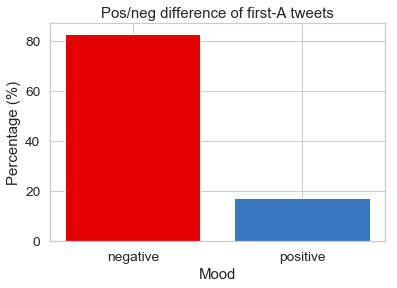

In [277]:
count=c_df['class'].value_counts()/len(c_df['tweet'])*100
Index = [1,2]
colorsi = ["red", "windows blue"]
plt.bar(Index, count, color=sns.xkcd_palette(colorsi))
plt.xticks(Index,['negative','positive'])
plt.ylabel('Percentage (%)')
plt.xlabel('Mood')
plt.title('Pos/neg difference of first-A tweets');

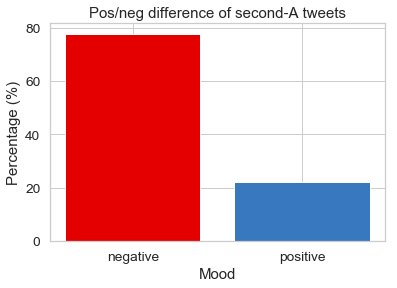

In [311]:
count=c_df2['class'].value_counts()/len(c_df2['tweet'])*100
Index = [1,2]
colorsi = ["red", "windows blue"]
plt.bar(Index, count, color=sns.xkcd_palette(colorsi))
plt.xticks(Index,['negative','positive'])
plt.ylabel('Percentage (%)')
plt.xlabel('Mood')
plt.title('Pos/neg difference of second-A tweets');

- KLM has 443 First-A's (received tweets) and 486 Second-A's (replies to KLM's reply to the first-A)                           
- Majority is complaints (negative tweets) from both first-A and second-A

- Second-A tweets are basically people complaining about the response time or them expanding on what their initial problem was

In [312]:
c_df2['class'].value_counts()

neg    378
pos    108
Name: class, dtype: int64

In [313]:
c_df['class'].value_counts()

neg    367
pos     76
Name: class, dtype: int64

* Getting A-B-A convos from British Airways - 18332190 and Singapore Air - 253340062 (for comparison)

In [72]:
unfiltered_a_q_brit = """
SELECT DISTINCT(id) as 'start', user as 'user_id'
FROM tweets
WHERE tweets.user != 18332190 AND tweets.id IN ({0}) AND tweets.in_reply_to_user_id = 'null' 
AND id IN (SELECT DISTINCT(in_reply_to_status_id) FROM tweets WHERE user = 18332190 AND in_reply_to_status_id != 'null')
""".format(','.join([str(x) for x in air_count['British_Airways']['ids']]))

unfiltered_a_brit = pd.read_sql_query(unfiltered_a_q_brit, db)
#unfiltered_a_brit

In [73]:
b_tweets_id_brit = """(SELECT DISTINCT(id) FROM tweets WHERE tweets.user = 18332190 AND in_reply_to_status_id IN ({0}))""".format( ','.join([str(x) for x in unfiltered_a_brit['start']]))
b_tweets_in_reply_user_brit = """(SELECT DISTINCT(in_reply_to_user_id) FROM tweets WHERE tweets.user = 18332190 AND in_reply_to_status_id IN ({0}))""".format( ','.join([str(x) for x in unfiltered_a_brit['start']]))
a_tweets_brit = """(SELECT DISTINCT(in_reply_to_status_id) FROM tweets WHERE tweets.user = 18332190 AND in_reply_to_status_id IN ({0}))""".format( ','.join([str(x) for x in unfiltered_a_brit['start']]))
backward_a_b_q_brit = """
SELECT DISTINCT(id) as 'change', user as 'user_id', in_reply_to_status_id as 'brits reply'
FROM tweets
WHERE tweets.user != 18332190 AND tweets.id IN ({0}) AND tweets.user IN {1}
AND tweets.in_reply_to_status_id IN {2}
""".format(','.join([str(x) for x in air_count['British_Airways']['ids']]), b_tweets_in_reply_user_brit, b_tweets_id_brit)
backward_a_b_brit = pd.read_sql_query(backward_a_b_q_brit, db)
#backward_a_b_brit

In [74]:
a_tweets_q_brit = """
SELECT in_reply_to_status_id as 'start'
FROM tweets
WHERE id IN ({0})
""".format(','.join([str(x) for x in backward_a_b_brit['brits reply']]))
a_tweets_brit = pd.read_sql_query(a_tweets_q_brit, db)
#a_tweets_brit

                                  First-A tweets for brit

In [75]:
brit_id = []
for i in a_tweets_brit['start']:
    brit_id.append(i)
len(brit_id)

2705

In [76]:
brit_df = pd.DataFrame()
brit_df['tweet'] = [t['text'] for t in tweets.find({}) for i in brit_id if i == t['id'] if t['language']=='eng']
brit_df['id'] = [t['id'] for t in tweets.find({}) for i in brit_id if i == t['id'] if t['language']=='eng']
brit_df['user_id'] = [t['user']['id'] for t in tweets.find({}) for i in brit_id if i == t['id'] if t['language']=='eng']
brit_df['timestamp'] = [t['timestamp_ms'] for t in tweets.find({}) for i in brit_id if i == t['id'] if t['language']=='eng']

In [77]:
brit_df.drop_duplicates(inplace=True)
#brit_df

In [78]:
brit_df['tweet'] = brit_df['tweet'].apply(cleantxt)
#brit_df[['tweet']]

In [79]:
from collections import Counter
cnt = Counter()
for text in brit_df["tweet"].values:
    for word in text.split():
        cnt[word] += 1       
#cnt.most_common(35)

In [80]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(35)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

brit_df['tweet'] = brit_df['tweet'].apply(remove_freqwords)
#brit_df[['tweet']].head()

In [286]:
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

brit_df['tweet'] = brit_df['tweet'].apply(deEmojify)

In [287]:
brit_df['polarity'] = brit_df['tweet'].apply(getPolarity)
brit_df['subjectivity'] = brit_df['tweet'].apply(getSubjectivity)
brit_df['analysis'] = brit_df['polarity'].apply(getAnalysis)

In [288]:
brit_df['class'] = brit_df['tweet'].apply(classify)

In [289]:
brit_df['class'].value_counts()

neg    1968
pos     547
Name: class, dtype: int64

                                         Second-A tweets for brit

In [83]:
brit_id2 = []
for i in backward_a_b_brit['change']:
    brit_id2.append(i)
len(brit_id2)

2793

In [84]:
brit_df2 = pd.DataFrame()
brit_df2['tweet'] = [t['text'] for t in tweets.find({}) for i in brit_id2 if i == t['id'] if t['language']=='eng']
brit_df2['id'] = [t['id'] for t in tweets.find({}) for i in brit_id2 if i == t['id'] if t['language']=='eng']
brit_df2['user_id'] = [t['user']['id'] for t in tweets.find({}) for i in brit_id2 if i == t['id'] if t['language']=='eng']
brit_df2['timestamp'] = [t['timestamp_ms'] for t in tweets.find({}) for i in brit_id2 if i == t['id'] if t['language']=='eng']

In [85]:
brit_df2.drop_duplicates(inplace=True)
#brit_df2

In [86]:
brit_df2['tweet'] = brit_df2['tweet'].apply(cleantxt)
#brit_df[['tweet']]

In [87]:
from collections import Counter
cnt = Counter()
for text in brit_df2["tweet"].values:
    for word in text.split():
        cnt[word] += 1       
#cnt.most_common(35)

In [88]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(35)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

brit_df2['tweet'] = brit_df2['tweet'].apply(remove_freqwords)
#brit_df[['tweet']].head()

In [290]:
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

brit_df2['tweet'] = brit_df2['tweet'].apply(deEmojify)

In [291]:
brit_df2['polarity'] = brit_df2['tweet'].apply(getPolarity)
brit_df2['subjectivity'] = brit_df2['tweet'].apply(getSubjectivity)
brit_df2['analysis'] = brit_df2['polarity'].apply(getAnalysis)

In [292]:
brit_df2['class'] = brit_df2['tweet'].apply(classify)

In [293]:
brit_df2['class'].value_counts()

neg    2235
pos     554
Name: class, dtype: int64

                                First-A tweets for singa

In [93]:
unfiltered_a_q_singa = """
SELECT DISTINCT(id) as 'start', user as 'user_id'
FROM tweets
WHERE tweets.user != 253340062 AND tweets.id IN ({0}) AND tweets.in_reply_to_user_id = 'null' 
AND id IN (SELECT DISTINCT(in_reply_to_status_id) FROM tweets WHERE user = 253340062 AND in_reply_to_status_id != 'null')
""".format(','.join([str(x) for x in air_count['SingaporeAir']['ids']]))

unfiltered_a_singa = pd.read_sql_query(unfiltered_a_q_singa, db)
#unfiltered_a_singa

In [94]:
b_tweets_id_singa = """(SELECT DISTINCT(id) FROM tweets WHERE tweets.user = 253340062 AND in_reply_to_status_id IN ({0}))""".format( ','.join([str(x) for x in unfiltered_a_singa['start']]))
b_tweets_in_reply_user_singa = """(SELECT DISTINCT(in_reply_to_user_id) FROM tweets WHERE tweets.user = 253340062 AND in_reply_to_status_id IN ({0}))""".format( ','.join([str(x) for x in unfiltered_a_singa['start']]))
a_tweets_singa = """(SELECT DISTINCT(in_reply_to_status_id) FROM tweets WHERE tweets.user = 253340062 AND in_reply_to_status_id IN ({0}))""".format( ','.join([str(x) for x in unfiltered_a_singa['start']]))
backward_a_b_q_singa = """
SELECT DISTINCT(id) as 'change', user as 'user_id', in_reply_to_status_id as 'singas reply'
FROM tweets
WHERE tweets.user != 18332190 AND tweets.id IN ({0}) AND tweets.user IN {1}
AND tweets.in_reply_to_status_id IN {2}
""".format(','.join([str(x) for x in air_count['SingaporeAir']['ids']]), b_tweets_in_reply_user_singa, b_tweets_id_singa)
backward_a_b_singa = pd.read_sql_query(backward_a_b_q_singa, db)
#backward_a_b_singa

In [95]:
a_tweets_q_singa = """
SELECT in_reply_to_status_id as 'start'
FROM tweets
WHERE id IN ({0})
""".format(','.join([str(x) for x in backward_a_b_singa['singas reply']]))
a_tweets_singa = pd.read_sql_query(a_tweets_q_singa, db)
#a_tweets_singa

In [96]:
singa_id = []
for i in a_tweets_singa['start']:
    singa_id.append(i)
len(singa_id)

261

In [97]:
singa_df = pd.DataFrame()
singa_df['tweet'] = [t['text'] for t in tweets.find({}) for i in singa_id if i == t['id'] if t['language']=='eng']
singa_df['id'] = [t['id'] for t in tweets.find({}) for i in singa_id if i == t['id'] if t['language']=='eng']
singa_df['user_id'] = [t['user']['id'] for t in tweets.find({}) for i in singa_id if i == t['id'] if t['language']=='eng']
singa_df['timestamp'] = [t['timestamp_ms'] for t in tweets.find({}) for i in singa_id if i == t['id'] if t['language']=='eng']

In [98]:
singa_df.drop_duplicates(inplace=True)
singa_df['tweet'] = singa_df['tweet'].apply(cleantxt)

In [99]:
cnt = Counter()
for text in singa_df["tweet"].values:
    for word in text.split():
        cnt[word] += 1       
#cnt.most_common(35)

In [100]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(35)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

singa_df['tweet'] = singa_df['tweet'].apply(remove_freqwords)

In [294]:
singa_df['tweet'] = singa_df['tweet'].apply(deEmojify)

In [295]:
singa_df['polarity'] = singa_df['tweet'].apply(getPolarity)
singa_df['subjectivity'] = singa_df['tweet'].apply(getSubjectivity)
singa_df['analysis'] = singa_df['polarity'].apply(getAnalysis)
singa_df['class'] = singa_df['tweet'].apply(classify)

                                         Second-A tweets for singa

In [102]:
singa_id2 = []
for i in backward_a_b_singa['change']:
    singa_id2.append(i)
len(singa_id2)

274

In [103]:
singa_df2 = pd.DataFrame()
singa_df2['tweet'] = [t['text'] for t in tweets.find({}) for i in singa_id2 if i == t['id'] if t['language']=='eng']
singa_df2['id'] = [t['id'] for t in tweets.find({}) for i in singa_id2 if i == t['id'] if t['language']=='eng']
singa_df2['user_id'] = [t['user']['id'] for t in tweets.find({}) for i in singa_id2 if i == t['id'] if t['language']=='eng']
singa_df2['timestamp'] = [t['timestamp_ms'] for t in tweets.find({}) for i in singa_id2 if i == t['id'] if t['language']=='eng']

In [104]:
singa_df2.drop_duplicates(inplace=True)
singa_df2['tweet'] = singa_df2['tweet'].apply(cleantxt)

In [105]:
cnt = Counter()
for text in singa_df2["tweet"].values:
    for word in text.split():
        cnt[word] += 1 
    
FREQWORDS = set([w for (w, wc) in cnt.most_common(35)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

singa_df2['tweet'] = singa_df2['tweet'].apply(remove_freqwords)

In [297]:
singa_df2['tweet'] = singa_df2['tweet'].apply(deEmojify)

In [298]:
singa_df2['polarity'] = singa_df2['tweet'].apply(getPolarity)
singa_df2['subjectivity'] = singa_df2['tweet'].apply(getSubjectivity)
singa_df2['analysis'] = singa_df2['polarity'].apply(getAnalysis)
singa_df2['class'] = singa_df2['tweet'].apply(classify)

### Comparison of the convo sentiment change between KLM, British Airways and Singapore Air
All three airlines have more second-A tweets (replies to KLM's reply) than first-A tweets (initial sent tweets to KLM).    
They all have around 80% negative first-A tweets and then it drops after airlines reply, tho not significantly.                                                           
After replying to their costumers (visualization below):
* KLM negative sentiment is ~4% lower 
* British Airways negative sentiment is ~2% higher
* Singapore Air negative seniment is ~10% lower

In [331]:
brit_df.shape, brit_df2.shape, singa_df.shape, singa_df2.shape

((2515, 8), (2789, 8), (246, 8), (274, 8))

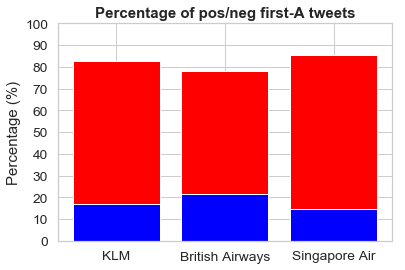

In [332]:
#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
#fig.suptitle('Conversation Sentiment Change', fontsize=16)

p1 = plt.bar(0,(c_df['class'].value_counts()/len(c_df['tweet'])*100)['neg'], color='red')
p2 = plt.bar(0,(c_df['class'].value_counts()/len(c_df['tweet'])*100)['pos'], color='blue')
p3 = plt.bar(1,(brit_df['class'].value_counts()/len(brit_df['tweet'])*100)['neg'], color='red')
p4 = plt.bar(1,(brit_df['class'].value_counts()/len(brit_df['tweet'])*100)['pos'], color='blue')
p5 = plt.bar(2,(singa_df['class'].value_counts()/len(singa_df['tweet'])*100)['neg'], color='red')
p6 = plt.bar(2,(singa_df['class'].value_counts()/len(singa_df['tweet'])*100)['pos'], color='blue')

plt.ylabel('Percentage (%)')
plt.title('Percentage of pos/neg first-A tweets', weight='bold')
plt.xticks(ind, ('KLM', 'British Airways','Singapore Air'))
plt.yticks(np.arange(0, 101,10));
#plt.legend((p1[0], p2[0]), ('neg', 'pos'))

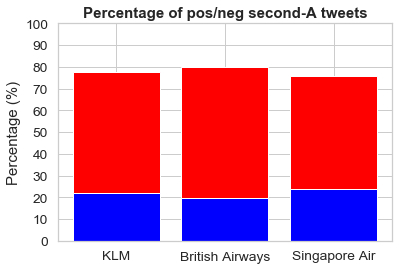

In [333]:
p7 = plt.bar(0,(c_df2['class'].value_counts()/len(c_df2['tweet'])*100)['neg'], color='red')
p8 = plt.bar(0,(c_df2['class'].value_counts()/len(c_df2['tweet'])*100)['pos'], color='blue')
p9 = plt.bar(1,(brit_df2['class'].value_counts()/len(brit_df2['tweet'])*100)['neg'], color='red')
p10 = plt.bar(1,(brit_df2['class'].value_counts()/len(brit_df2['tweet'])*100)['pos'], color='blue')
p11 = plt.bar(2,(singa_df2['class'].value_counts()/len(singa_df2['tweet'])*100)['neg'], color='red')
p12 = plt.bar(2,(singa_df2['class'].value_counts()/len(singa_df2['tweet'])*100)['pos'], color='blue') 

plt.ylabel('Percentage (%)')
plt.title('Percentage of pos/neg second-A tweets', weight='bold')
plt.xticks(ind, ('KLM', 'British Airways','Singapore Air'))
plt.yticks(np.arange(0, 101,10));

Based on TextBlob (mean - see below):
* KLM's sentiment changed from 0.03 to 0.08 
* British Airways' sentiment changed from 0.03 to 0.06
* Singapore Air's sentiment changed from 0.04 to 0.08

In [320]:
c_df['polarity'].describe(), c_df2['polarity'].describe()

(count    443.000000
 mean       0.038061
 std        0.270283
 min       -1.000000
 25%       -0.080556
 50%        0.021429
 75%        0.200000
 max        0.800000
 Name: polarity, dtype: float64, count    486.000000
 mean       0.086636
 std        0.240292
 min       -1.000000
 25%       -0.012798
 50%        0.066667
 75%        0.216406
 max        0.900000
 Name: polarity, dtype: float64)

In [321]:
brit_df['polarity'].describe(), brit_df2['polarity'].describe()

(count    2515.000000
 mean        0.032342
 std         0.280503
 min        -1.000000
 25%        -0.100000
 50%         0.000000
 75%         0.200000
 max         1.000000
 Name: polarity, dtype: float64, count    2789.000000
 mean        0.068385
 std         0.248806
 min        -1.000000
 25%        -0.050000
 50%         0.050000
 75%         0.207143
 max         1.000000
 Name: polarity, dtype: float64)

In [322]:
singa_df['polarity'].describe(), singa_df2['polarity'].describe()

(count    246.000000
 mean       0.041882
 std        0.298900
 min       -1.000000
 25%       -0.100000
 50%        0.000000
 75%        0.225000
 max        0.800000
 Name: polarity, dtype: float64, count    274.000000
 mean       0.085270
 std        0.256626
 min       -1.000000
 25%       -0.015000
 50%        0.076894
 75%        0.239524
 max        0.910000
 Name: polarity, dtype: float64)

In [112]:
klm_reply_id = []
for i in backward_a_b['klms reply']:
    klm_reply_id.append(i)
len(klm_reply_id)
#klm_reply_id

775

In [590]:
klm_reply = pd.DataFrame()
klm_reply['tweet'] = [t['text'] for t in tweets.find({}) for i in klm_reply_id if i == t['id'] if t['language']=='eng']
klm_reply['id'] = [t['id'] for t in tweets.find({}) for i in klm_reply_id if i == t['id'] if t['language']=='eng']
klm_reply['user_id'] = [t['user']['id'] for t in tweets.find({}) for i in klm_reply_id if i == t['id'] if t['language']=='eng']
klm_reply['timestamp'] = [t['timestamp_ms'] for t in tweets.find({}) for i in klm_reply_id if i == t['id'] if t['language']=='eng']

In [593]:
klm_reply.drop_duplicates().head(20)

,tweet,id,user_id,timestamp
0,"@recklesscitizen We regret to hear your baggage has been delayed. Have you created a PIR with us? If you still have to do so, you can create this report via https://t.co/h5Uo0XLysN.",1139414658421387300,56377143,1560492598525
1,"@Golsong We regret to read this. Have you created a PIR with us? If you still have to do so, you can create this report via https://t.co/h5Uo0Y39Rn.",1135269182281539600,56377143,1559504239994
2,"@mumbaimuscat As a global carrier, KLM values all of its passengers. We do not distinguish between age, gender, race, religion or lifestyle. Can you please elaborate your concern so we can assist you further? Please share your booking code and ticket number via private message.",1135500525686931500,56377143,1559559396560
5,"@pryonic We regret to read this, Jamie. If all your flights are booked in one ticket, you will be automatically rebooked to the next available flight if you miss your connection in the unfortunate event of a delay. Please send us a DM if you need further assistance.",1137132936950669300,56377143,1559948593734
6,"@TapanSh28133927 We regret to hear this. Thank you for bringing this to our attention. Could you kindly share your full name, flight number, date and seat number via a DM?",1137306741576802300,56377143,1559990031986
8,@tommygbyrne We are sorry to read this. We would like to advise you to arrange the necessary accommodation yourself. Afterwards you can claim the costs with our Customer Care department: https://t.co/2Y6XnE3Ox4.,1137359666483204100,56377143,1560002650267
9,"@jornandinha KLM introduced three new types of Economy tickets at the end of 2017 on routes within Europe to/from North America: Light, Standard and Flex. This has been gradually phased in on Central and South American routes, in the Caribbean, Africa, and now Asia and the Middle East. &gt;&gt;",1133833504041635800,56377143,1559161947628
10,"@TurkKenya Thank you for reaching out to us. We’re sorry to read this. Normal use of your baggage may result in scratches, marks and small dents on your baggage and in other wear and tear. We are not liable for this. 1/2",1136780373977980900,56377143,1559864536171
11,"@virajpari We regret reading this. We can understand that this was not how you expected your journey to go. For unforeseen expenses due to a cancellation or a flight delay, you may request for possible compensation through this link here: https://t.co/y6e6TyT6j4.",1136783067056681000,56377143,1559865178251
12,"@carlopiana We appreciate you bringing this to our attention. We are thankful that you shared your story with us as we are very open to feedback. That way, we are able to find out the areas that we still need to improve on. Thank you.",1137370751319912400,56377143,1560005293098


* Getting 10 most used words before and after KLM replied

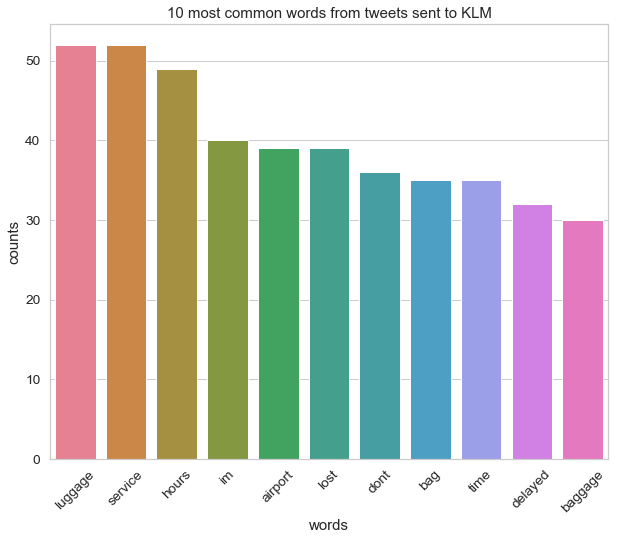

In [324]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
#Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:18]
    nogo = ['just','customer','flying','really','way','thanks','hey','passengers']
    words = [w[0] for w in count_dict if w[0] not in nogo]
    counts = [w[1] for w in count_dict if w[0] not in nogo]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(10, 8))
    plt.subplot(title='10 most common words from tweets sent to KLM')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=45) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
#Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
#Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(c_df['tweet'])
#Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

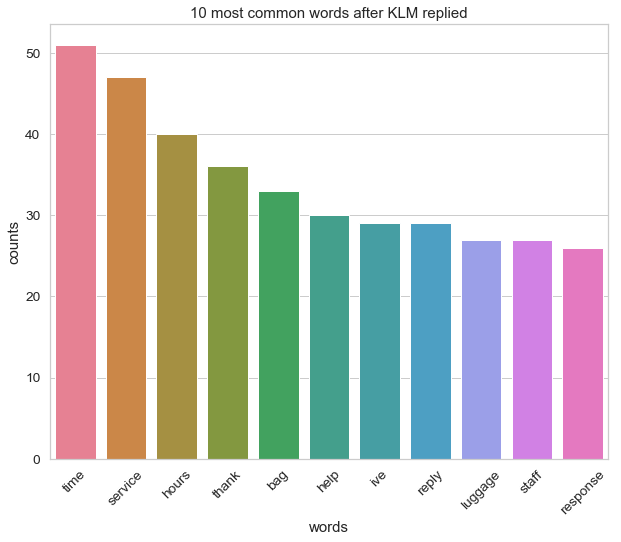

In [326]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:25]
    nogo = ['thanks','know','need','dont','really','airport','flying','customer','im','make','want','passengers','did','don','sure','days','like']
    words = [w[0] for w in count_dict if w[0] not in nogo]
    counts = [w[1] for w in count_dict if w[0] not in nogo]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(10, 8))
    plt.subplot(title='10 most common words after KLM replied')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=45) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
#Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
#Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(c_df2['tweet'])
#Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)